## Setup

In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os
warnings.filterwarnings('ignore')

#scaling
from sklearn.preprocessing import StandardScaler, OrdinalEncoder

# modeling
from sklearn.model_selection import train_test_split

from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBRFClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import log_loss

from catboost import Pool
from sklearn.metrics import log_loss
from optuna import create_study
from optuna.samplers import TPESampler

from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

In [2]:
# 깔금한 그래프 출력을 위해
%matplotlib inline
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

sns.set_style("whitegrid")

In [3]:
# 한글 폰트 설정
from matplotlib import font_manager, rc
f_path = "c:/Windows/Fonts/malgun.ttf"
font_name = font_manager.FontProperties(fname=f_path).get_name()
rc('font', family=font_name)

# 음수 기호
plt.rcParams['axes.unicode_minus'] = False

#### 변수 설명

index


gender: 성별


car: 차량 소유 여부


reality: 부동산 소유 여부


child_num: 자녀 수


income_total: 연간 소득


income_type: 소득 분류
['Commercial associate', 'Working', 'State servant', 'Pensioner', 'Student']



edu_type: 교육 수준
['Higher education' ,'Secondary / secondary special', 'Incomplete higher', 'Lower secondary', 'Academic degree']



family_type: 결혼 여부
['Married', 'Civil marriage', 'Separated', 'Single / not married', 'Widow']



house_type: 생활 방식
['Municipal apartment', 'House / apartment', 'With parents', 'Co-op apartment', 'Rented apartment', 'Office apartment']



DAYS_BIRTH: 출생일,
데이터 수집 당시 (0)부터 역으로 셈, 즉, -1은 데이터 수집일 하루 전에 태어났음을 의미



DAYS_EMPLOYED: 업무 시작일, 
데이터 수집 당시 (0)부터 역으로 셈, 즉, -1은 데이터 수집일 하루 전부터 일을 시작함을 의미 양수 값은 고용되지 않은 상태를 의미함



FLAG_MOBIL: 핸드폰 소유 여부


work_phone: 업무용 전화 소유 여부


phone: 전화 소유 여부 (가정용)


email: 이메일 소유 여부


occyp_type: 직업 유형													


family_size: 가족 규모


begin_month: 신용카드 발급 월
데이터 수집 당시 (0)부터 역으로 셈, 즉, -1은 데이터 수집일 한 달 전에 신용카드를 발급함을 의미


credit: 사용자의 신용카드 대금 연체를 기준으로 한 신용도
    => 낮을 수록 높은 신용의 신용카드 사용자를 의미함

#### 데이터 불러오기

In [4]:
data = pd.read_csv('data/train.csv')
data.head()

,index,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,begin_month,credit
0,0,F,N,N,0,202500.0,Commercial associate,Higher education,Married,Municipal apartment,-13899,-4709,1,0,0,0,NaN,2.0,-6.0,1.0
1,1,F,N,Y,1,247500.0,Commercial associate,Secondary / secondary special,Civil marriage,House / apartment,-11380,-1540,1,0,0,1,Laborers,3.0,-5.0,1.0
2,2,M,Y,Y,0,450000.0,Working,Higher education,Married,House / apartment,-19087,-4434,1,0,1,0,Managers,2.0,-22.0,2.0
3,3,F,N,Y,0,202500.0,Commercial associate,Secondary / secondary special,Married,House / apartment,-15088,-2092,1,0,1,0,Sales staff,2.0,-37.0,0.0
4,4,F,Y,Y,0,157500.0,State servant,Higher education,Married,House / apartment,-15037,-2105,1,0,0,0,Managers,2.0,-26.0,2.0


In [5]:
data.shape

(26457, 20)

## Preprocessing & EDA

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26457 entries, 0 to 26456
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   index          26457 non-null  int64  
 1   gender         26457 non-null  object 
 2   car            26457 non-null  object 
 3   reality        26457 non-null  object 
 4   child_num      26457 non-null  int64  
 5   income_total   26457 non-null  float64
 6   income_type    26457 non-null  object 
 7   edu_type       26457 non-null  object 
 8   family_type    26457 non-null  object 
 9   house_type     26457 non-null  object 
 10  DAYS_BIRTH     26457 non-null  int64  
 11  DAYS_EMPLOYED  26457 non-null  int64  
 12  FLAG_MOBIL     26457 non-null  int64  
 13  work_phone     26457 non-null  int64  
 14  phone          26457 non-null  int64  
 15  email          26457 non-null  int64  
 16  occyp_type     18286 non-null  object 
 17  family_size    26457 non-null  float64
 18  begin_

In [7]:
data = data.astype({'credit':'object'})

In [8]:
# 수치형, 범주형 변수
print('Numerical:', len(data.dtypes[data.dtypes != "object"].index),'\nCategorical:', len(data.dtypes[data.dtypes == "object"].index)-1)

Numerical: 11 
Categorical: 8


### 1) 시각화

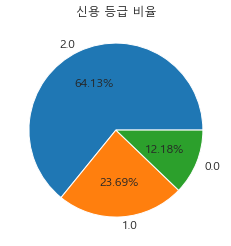

In [9]:
# 신용 등급 비율

plt.pie(data['credit'].value_counts(),
       autopct='%1.2f%%',
       textprops={'fontsize':12},
        labels=data['credit'].value_counts().index)

plt.title('신용 등급 비율')
plt.show()

#### 1) 범주형 변수

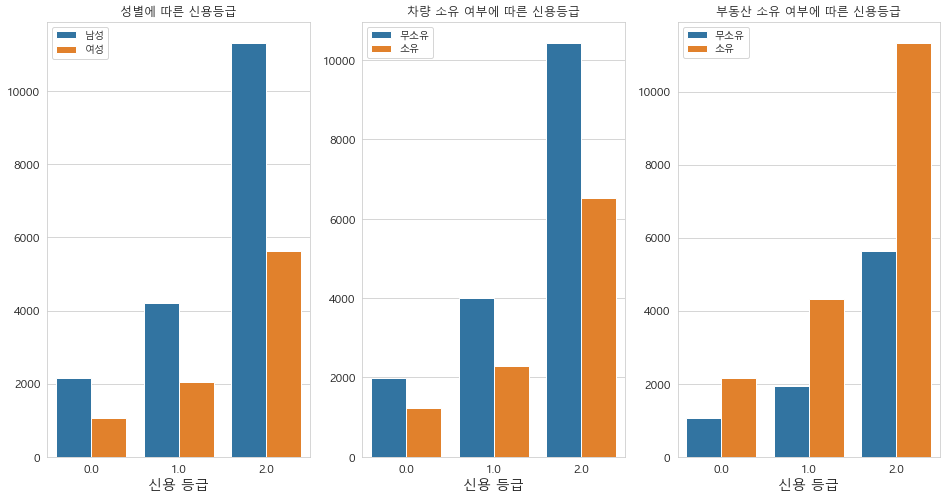

In [10]:
# 신용등급에 따른 성별, 차량, 부동산

fig = plt.figure(figsize=(16,8))

fig.add_subplot(1,3,1)
sns.countplot(data=data,
             x='credit',
             hue='gender')

plt.title('성별에 따른 신용등급')
plt.xlabel('신용 등급')
plt.ylabel('')
plt.legend(['남성','여성'])

fig.add_subplot(1,3,2)
sns.countplot(data=data,
             x='credit',
             hue='car')

plt.title('차량 소유 여부에 따른 신용등급')
plt.xlabel('신용 등급')
plt.ylabel('')
plt.legend(['무소유','소유'])

fig.add_subplot(1,3,3)
sns.countplot(data=data,
             x='credit',
             hue='reality')

plt.title('부동산 소유 여부에 따른 신용등급')
plt.xlabel('신용 등급')
plt.ylabel('')
plt.legend(['무소유','소유'])

plt.show()

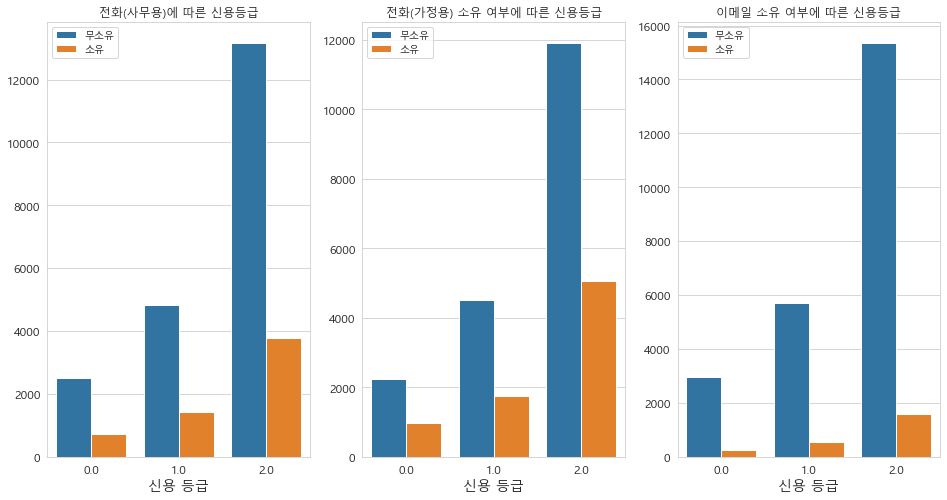

In [11]:
# 신용등급에 따른 전화, 이메일 소유 여부

fig = plt.figure(figsize=(16,8))

fig.add_subplot(1,3,1)
sns.countplot(data=data,
             x='credit',
             hue='work_phone')

plt.title('전화(사무용)에 따른 신용등급')
plt.xlabel('신용 등급')
plt.ylabel('')
plt.legend(['무소유','소유'])

fig.add_subplot(1,3,2)
sns.countplot(data=data,
             x='credit',
             hue='phone')

plt.title('전화(가정용) 소유 여부에 따른 신용등급')
plt.xlabel('신용 등급')
plt.ylabel('')
plt.legend(['무소유','소유'])

fig.add_subplot(1,3,3)
sns.countplot(data=data,
             x='credit',
             hue='email')

plt.title('이메일 소유 여부에 따른 신용등급')
plt.xlabel('신용 등급')
plt.ylabel('')
plt.legend(['무소유','소유'])

plt.show()

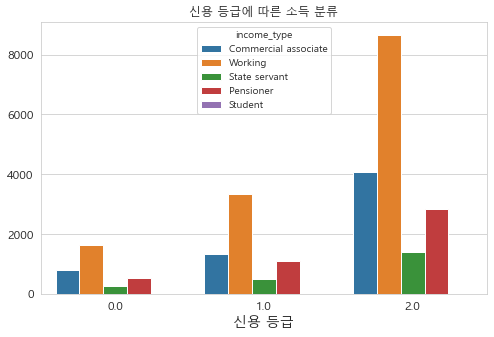

In [12]:
# 신용등급에 따른 소득 분류

plt.figure(figsize=(8,5))
sns.countplot(data=data,
              x='credit',
              hue='income_type')

plt.title('신용 등급에 따른 소득 분류')
plt.xlabel('신용 등급')
plt.ylabel('')

plt.show()

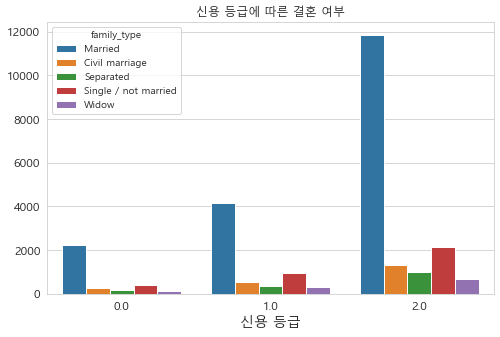

In [13]:
# 신용등급에 따른 결혼 여부

plt.figure(figsize=(8,5))
sns.countplot(data=data,
              x='credit',
              hue='family_type')

plt.title('신용 등급에 따른 결혼 여부')
plt.xlabel('신용 등급')
plt.ylabel('')

plt.show()

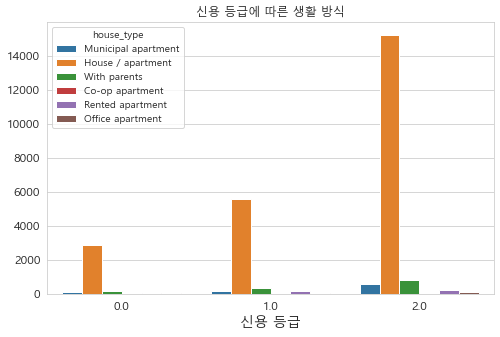

In [14]:
# 신용등급에 따른 생활 방식

plt.figure(figsize=(8,5))
sns.countplot(data=data,
              x='credit',
              hue='house_type')

plt.title('신용 등급에 따른 생활 방식')
plt.xlabel('신용 등급')
plt.ylabel('')

plt.show()

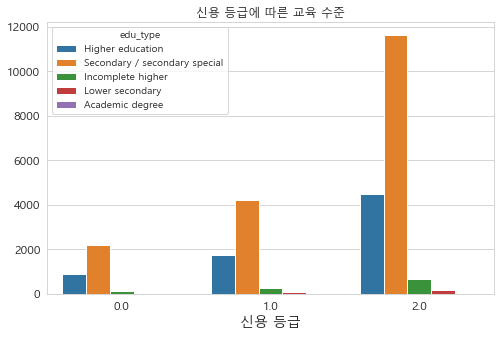

In [15]:
# 신용등급에 따른 교육 수준

plt.figure(figsize=(8,5))
sns.countplot(data=data,
              x='credit',
              hue='edu_type')

plt.title('신용 등급에 따른 교육 수준')
plt.xlabel('신용 등급')
plt.ylabel('')

plt.show()

In [16]:
data_y0 = data[data['credit']==0]
data_y1 = data[data['credit']==1]
data_y2 = data[data['credit']==2]

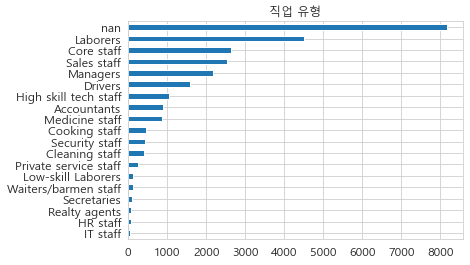

In [17]:
data_occyp = data['occyp_type'].value_counts(dropna = False).sort_values(ascending=True)
data_occyp.plot(kind='barh')

plt.title('직업 유형')
plt.xlabel('')
plt.ylabel('')

plt.show()

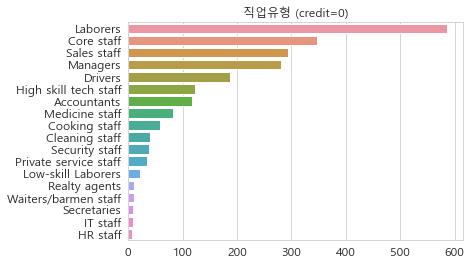

In [18]:
sns.barplot(data_y0['occyp_type'].value_counts(dropna=False).sort_values(ascending=False),
           y=data_y0['occyp_type'].value_counts(dropna=False).sort_values(ascending=False).index,)

plt.title('직업유형 (credit=0)')
plt.xlabel('')
plt.ylabel('')

plt.show()

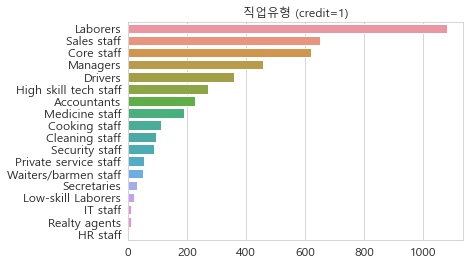

In [19]:
sns.barplot(data_y1['occyp_type'].value_counts().sort_values(ascending=False),
           y=data_y1['occyp_type'].value_counts().sort_values(ascending=False).index)

plt.title('직업유형 (credit=1)')
plt.xlabel('')
plt.ylabel('')

plt.show()

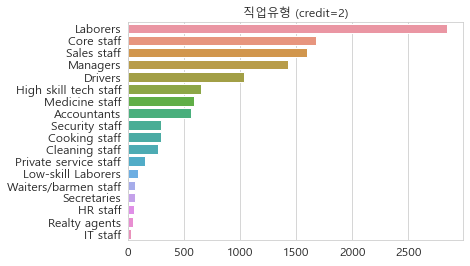

In [20]:
sns.barplot(data_y2['occyp_type'].value_counts().sort_values(ascending=False),
           y=data_y2['occyp_type'].value_counts().sort_values(ascending=False).index)

plt.title('직업유형 (credit=2)')
plt.xlabel('')
plt.ylabel('')

plt.show()

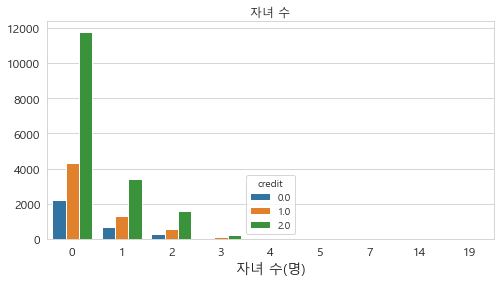

In [21]:
plt.figure(figsize=(8,4))
sns.countplot(data=data,
            x='child_num',
            hue='credit')

plt.title('자녀 수')
plt.xlabel('자녀 수(명)')
plt.ylabel('')

plt.show()

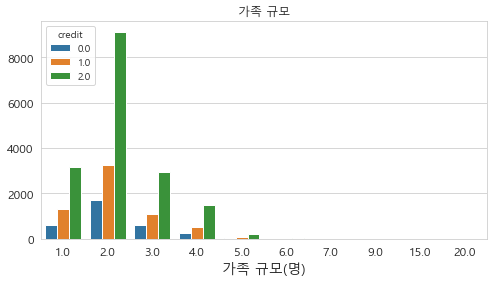

In [22]:
plt.figure(figsize=(8,4))
sns.countplot(data=data,
            x='family_size',
            hue='credit')

plt.title('가족 규모')
plt.xlabel('가족 규모(명)')
plt.ylabel('')

plt.show()

#### 2) 수치형 변수

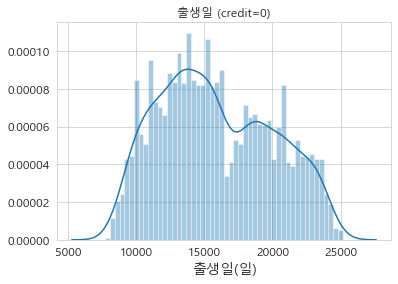

In [23]:
sns.distplot(-data_y0['DAYS_BIRTH'],bins=50)

plt.title('출생일 (credit=0)')
plt.xlabel('출생일(일)')
plt.ylabel('')

plt.show()

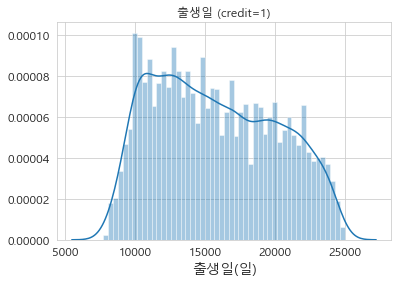

In [24]:
sns.distplot(-data_y1['DAYS_BIRTH'],bins=50)

plt.title('출생일 (credit=1)')
plt.xlabel('출생일(일)')
plt.ylabel('')

plt.show()

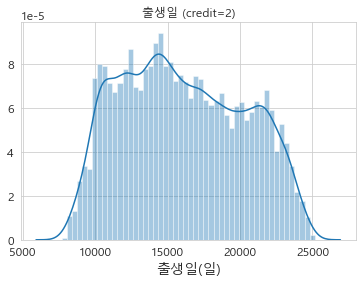

In [25]:
sns.distplot(-data_y2['DAYS_BIRTH'],bins=50)

plt.title('출생일 (credit=2)')
plt.xlabel('출생일(일)')
plt.ylabel('')

plt.show()

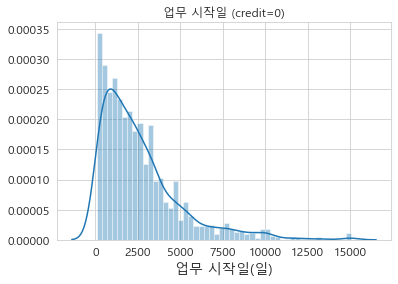

In [26]:
sns.distplot(-data_y0[data_y0['DAYS_EMPLOYED']<=0]['DAYS_EMPLOYED'],bins = 50)

plt.title('업무 시작일 (credit=0)')
plt.xlabel('업무 시작일(일)')
plt.ylabel('')

plt.show()

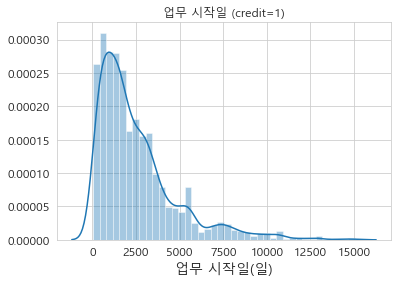

In [27]:
sns.distplot(-data_y1[data_y1['DAYS_EMPLOYED']<=0]['DAYS_EMPLOYED'],bins = 40)

plt.title('업무 시작일 (credit=1)')
plt.xlabel('업무 시작일(일)')
plt.ylabel('')

plt.show()

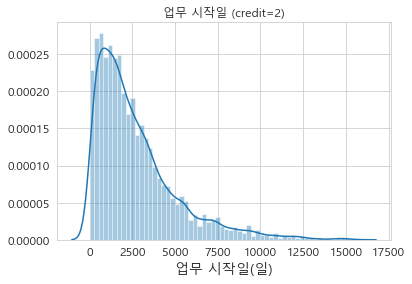

In [28]:
sns.distplot(-data_y2[data_y2['DAYS_EMPLOYED']<=0]['DAYS_EMPLOYED'],bins = 60)

plt.title('업무 시작일 (credit=2)')
plt.xlabel('업무 시작일(일)')
plt.ylabel('')

plt.show()

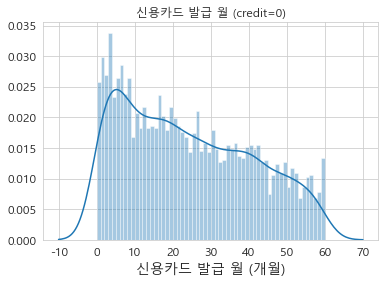

In [29]:
sns.distplot(-data_y0['begin_month'],bins=60)

plt.title('신용카드 발급 월 (credit=0)')
plt.xlabel('신용카드 발급 월 (개월)')
plt.ylabel('')

plt.show()

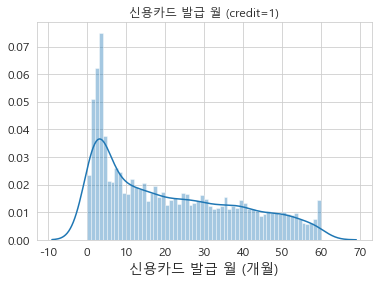

In [30]:
sns.distplot(-data_y1['begin_month'],bins=60)

plt.title('신용카드 발급 월 (credit=1)')
plt.xlabel('신용카드 발급 월 (개월)')
plt.ylabel('')

plt.show()

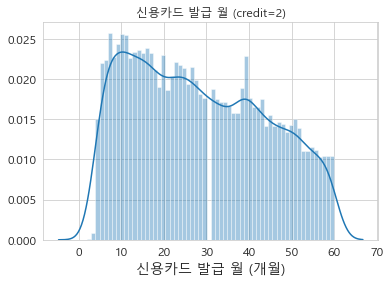

In [31]:
sns.distplot(-data_y2['begin_month'],bins=60)

plt.title('신용카드 발급 월 (credit=2)')
plt.xlabel('신용카드 발급 월 (개월)')
plt.ylabel('')

plt.show()

###  2) 결측치 제거 및 이상치 제거

#### a) occyp_type

In [32]:
data.isnull().sum()

index               0
gender              0
car                 0
reality             0
child_num           0
income_total        0
income_type         0
edu_type            0
family_type         0
house_type          0
DAYS_BIRTH          0
DAYS_EMPLOYED       0
FLAG_MOBIL          0
work_phone          0
phone               0
email               0
occyp_type       8171
family_size         0
begin_month         0
credit              0
dtype: int64

In [33]:
data['occyp_type'].fillna('inoccupation', inplace=True) # 결측치 => 무직으로 변경

#### b) FLAG_MOBIL & index

<AxesSubplot:xlabel='credit', ylabel='count'>

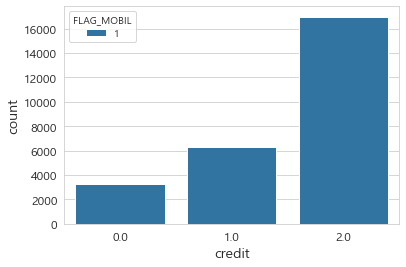

In [34]:
sns.countplot(data=data,
              x='credit',
             hue='FLAG_MOBIL')

In [35]:
data.FLAG_MOBIL.value_counts()

1    26457
Name: FLAG_MOBIL, dtype: int64

In [36]:
data.drop(['FLAG_MOBIL','index'],axis=1,inplace=True) # 핸드폰을 모두 소유하고 있어 제거

#### c) family_size & child_num

In [37]:
data.family_size.value_counts().sort_index()

1.0      5109
2.0     14106
3.0      4632
4.0      2260
5.0       291
6.0        44
7.0         9
9.0         2
15.0        3
20.0        1
Name: family_size, dtype: int64

In [38]:
data.child_num.value_counts().sort_index()

0     18340
1      5386
2      2362
3       306
4        47
5        10
7         2
14        3
19        1
Name: child_num, dtype: int64

In [39]:
data[data.family_size==15] # 중복 데이터 확인

,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,work_phone,phone,email,occyp_type,family_size,begin_month,credit
8462,M,Y,Y,14,225000.0,Working,Secondary / secondary special,Separated,House / apartment,-17754,-1689,0,0,0,Drivers,15.0,-7.0,2.0
9021,M,Y,Y,14,225000.0,Working,Secondary / secondary special,Separated,House / apartment,-17754,-1689,0,0,0,Drivers,15.0,-58.0,2.0
25390,M,Y,Y,14,225000.0,Working,Secondary / secondary special,Separated,House / apartment,-17754,-1689,0,0,0,Drivers,15.0,-43.0,2.0


In [40]:
data.drop(data[data['family_size'] >= 9].index, axis=0, inplace=True) # 이상치 제거

#### d) DAYS_EMPLOYED

In [41]:
data['DAYS_EMPLOYED'].value_counts().sort_index()

-15713        1
-15661        2
-15072        3
-15038       14
-14887        5
           ... 
-70           4
-65           1
-43           1
-17           2
 365243    4438
Name: DAYS_EMPLOYED, Length: 3469, dtype: int64

In [42]:
data[['DAYS_BIRTH','DAYS_EMPLOYED','begin_month']].head()

,DAYS_BIRTH,DAYS_EMPLOYED,begin_month
0,-13899,-4709,-6.0
1,-11380,-1540,-5.0
2,-19087,-4434,-22.0
3,-15088,-2092,-37.0
4,-15037,-2105,-26.0


In [43]:
data['DAYS_EMPLOYED'] = data['DAYS_EMPLOYED'].apply(lambda x : 0 if x==365243 else x) #365243 결측치 0 으로 채움

In [44]:
# 음수값 처리
data[['DAYS_BIRTH','DAYS_EMPLOYED','begin_month']]=  abs(data[['DAYS_BIRTH','DAYS_EMPLOYED','begin_month']]) # 음수로 되어 있는 columns에 절대값

#### e) work_phone	& phone & email

In [45]:
data = data.astype({'work_phone' : 'object', 'phone' : 'object','email' : 'object'})

### 3) 파생변수

In [46]:
# DAYS_BIRTH: 출생일 데이터 수집 당시 (0)부터 역으로 셈 => age(나이)
# DAYS_EMPLOYED: 업무 시작일 데이터 수집 당시 (0)부터 역으로 셈 => YEARS_EMPLOYED(n 연차)

data['age'] = (data['DAYS_BIRTH']/365).astype('int')
data['YEARS_EMPLOYED'] = (data['DAYS_EMPLOYED']/365+1).astype('int')

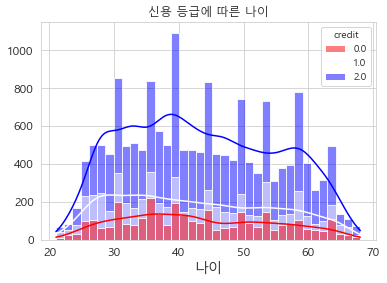

In [47]:
sns.histplot(data=data,
             x='age',
             hue='credit',
            kde=True,
            palette='bwr_r')

plt.title('신용 등급에 따른 나이')
plt.xlabel('나이')
plt.ylabel('')

plt.show()

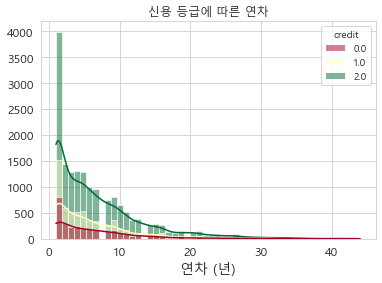

In [48]:
sns.histplot(data=data,
             x='YEARS_EMPLOYED',
             hue='credit',
            kde=True,
            palette='RdYlGn',
            bins=50)

plt.title('신용 등급에 따른 연차')
plt.xlabel('연차 (년)')
plt.ylabel('')

plt.show()

In [49]:
# 중복 데이터 처리 하기 위해 ID 변수를 생성

ID = np.zeros(data.shape[0],dtype='object')

data.reset_index(inplace=True, drop=True)

for idx in range(data.shape[0]):
    for col in data.columns.drop(['begin_month','credit']):
        if data[col].dtype =='object':
            ID[idx] = str(ID[idx]) + str(data[col][idx])[0:3]
        else:
            ID[idx] = str(ID[idx]) + str(data[col][idx])

data['Personal_ID'] = ID

In [50]:
# 중복 데이터 처리
len(data.Personal_ID.unique())

8756

### 4) Scaling

In [51]:
numerical_feats = data.dtypes[data.dtypes != "object"].index
categorical_feats = data.dtypes[data.dtypes == "object"].index
print('Numerical:', len(numerical_feats),'\nCategorical:', len(categorical_feats))

Numerical: 8 
Categorical: 13


In [52]:
data_num_idx = data.dtypes[data.dtypes!='object'].index
data_cat_idx = data.dtypes[data.dtypes=='object'].index

std_scaler = StandardScaler()
data[data_num_idx] = std_scaler.fit_transform(data[data_num_idx])

ordinal_encoder = OrdinalEncoder()
data[data_cat_idx] = ordinal_encoder.fit_transform(data[data_cat_idx])

In [53]:
# catboost
categorical_feats=['gender','car','reality','work_phone','phone','income_type', 'edu_type','family_type', 'house_type', 'occyp_type','Personal_ID']
data = data.astype({'gender':'int','car':'int','reality':'int','work_phone' : 'int', 'phone' : 'int','income_type':'int', 'edu_type':'int','family_type':'int', 'house_type':'int', 'occyp_type':'int', 'Personal_ID':'int'})

In [54]:
data.head()

,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,...,work_phone,phone,email,occyp_type,family_size,begin_month,credit,age,YEARS_EMPLOYED,Personal_ID
0,0,0,0,-0.589850,0.149115,0,1,1,2,-0.490076,...,0,0,0.0,18,-0.216262,-1.215242,1.0,-0.452826,0.994253,529
1,0,0,1,0.795036,0.590785,0,4,0,1,-1.089581,...,0,0,1.0,8,0.897294,-1.275633,1.0,-1.060773,-0.250471,3922
2,1,1,1,-0.589850,2.578304,4,1,1,1,0.744635,...,0,1,0.0,10,-0.216262,-0.248981,2.0,0.763069,0.994253,8273
3,0,0,1,-0.589850,0.149115,0,4,1,1,-0.207101,...,0,1,0.0,14,-0.216262,0.656889,0.0,-0.192277,-0.094880,2495
4,0,1,1,-0.589850,-0.292556,2,1,1,1,-0.219239,...,0,0,0.0,10,-0.216262,-0.007416,2.0,-0.192277,-0.094880,4932


## Modeling

## 1) train-valid test split

In [55]:
from sklearn.model_selection import train_test_split


X = data.drop(['credit','email'],axis=1)
y = data['credit']

X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, train_size=0.8, random_state=42 )

## 2) model select

In [53]:
# 모델 선택

dtc = DecisionTreeClassifier(random_state=42, max_depth=6)
svc = SVC(random_state=42, probability=True)
rfc = RandomForestClassifier(n_estimators=500, random_state=42, min_samples_split=50)
lgbm = LGBMClassifier(n_estimators=500,random_state=42)
xgb = XGBRFClassifier(random_state=42)
cat = CatBoostClassifier(n_estimators=500,verbose=0,random_state=42)

model_selection = [dtc,svc,rfc,lgbm,xgb,cat]

In [68]:
def logloss_model(model):
    folds=[]
    logloss_list=[]
    print('-'*40)
    print(f'{model.__class__.__name__}')

    skfold = StratifiedKFold(n_splits = 10, shuffle = True, random_state = 42)
    
    for train_idx, valid_idx in skfold.split(X_train_val, y_train_val):
        folds.append((train_idx, valid_idx))

    for fold in range(10):
        train_idx, valid_idx = folds[fold]
        X_train, X_valid, y_train, y_valid = X_train_val.iloc[train_idx], X_train_val.iloc[valid_idx],y_train_val.iloc[train_idx], y_train_val.iloc[valid_idx]
        
        if(model.__class__.__name__=='CatBoostClassifier'):
            clf = model.fit(X_train, y_train, cat_features=categorical_feats)
        else:
            clf = model.fit(X_train, y_train)
        y_pred_m = clf.predict_proba(X_valid)
        logloss = log_loss(y_valid, y_pred_m) 
        logloss_list.append(logloss)
        
        print(f'{fold+1}-Fold : {logloss}')
    
    print(f'log_loss_mean : {np.mean(logloss_list)}\n')

    return np.mean(logloss_list),model.__class__.__name__

In [69]:
model_select={}
logloss_value=[]
model_name=[]

for model in model_selection:
    score, name = logloss_model(model)
    logloss_value.append(score)
    model_name.append(name)

model_select['model']=model_name
model_select['log_loss']=logloss_value

model_select = pd.DataFrame(model_select)

----------------------------------------
DecisionTreeClassifier
1-Fold : 0.8764788857912408
2-Fold : 0.889536214578687
3-Fold : 0.9078123629369912
4-Fold : 0.8395159625609752
5-Fold : 0.9073642419067747
6-Fold : 0.8621319149040141
7-Fold : 0.8470064319112461
8-Fold : 0.9352470020910459
9-Fold : 0.9804800661556969
10-Fold : 0.8197937836093088
log_loss_mean : 0.8865366866445982

----------------------------------------
SVC
1-Fold : 0.8828498911322744
2-Fold : 0.8828445485972358
3-Fold : 0.8834666622343794
4-Fold : 0.8835489237827846
5-Fold : 0.8835936695512949
6-Fold : 0.8836151699971392
7-Fold : 0.8840782546066835
8-Fold : 0.8836951445207182
9-Fold : 0.8843683256782945
10-Fold : 0.8835759770735189
log_loss_mean : 0.8835636567174323

----------------------------------------
RandomForestClassifier
1-Fold : 0.7511630198944714
2-Fold : 0.7422073832806239
3-Fold : 0.7448505919759242
4-Fold : 0.7399420160131138
5-Fold : 0.7539666122189521
6-Fold : 0.760839681434596
7-Fold : 0.7722285950974953

In [76]:
model_select['model']=model_name
model_select['log_loss']=logloss_value

model_select = pd.DataFrame(model_select)
model_select.set_index('model')

,log_loss
model,
DecisionTreeClassifier,0.886537
SVC,0.883564
RandomForestClassifier,0.750888
LGBMClassifier,0.753788
XGBRFClassifier,0.826451
CatBoostClassifier,0.694329


<AxesSubplot:xlabel='log_loss', ylabel='model'>

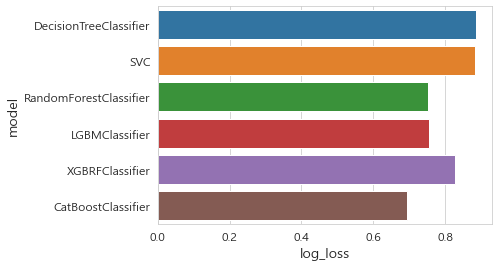

In [77]:
sns.barplot(data = model_select,
           x = 'log_loss',
           y = 'model')

## 3) Parameter Tuning

In [56]:
#Optuna를 활용한 파라미터 튜닝

def objective(trial):
    param = {
        "random_state":42,
        'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 1),
        'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 30, 100),
        "n_estimators":trial.suggest_int("n_estimators", 6000, 10000),
        "max_depth":trial.suggest_int("max_depth", 5, 20),
        'random_strength' :trial.suggest_int('random_strength', 0, 30),
        "min_child_samples": trial.suggest_int("min_child_samples", 50, 150),
        "max_bin": trial.suggest_int("max_bin", 100, 700)
    }
    
    X_train, X_valid, y_train, y_valid = train_test_split(X_train_val,y_train_val,train_size=0.8,random_state=42)
    train_data = Pool(data=X_train, label=y_train, cat_features=categorical_feats)
    valid_data = Pool(data=X_valid, label=y_valid, cat_features=categorical_feats)
    
    model_cat = CatBoostClassifier()
    model_cat.fit(train_data,
            eval_set = valid_data,
            early_stopping_rounds = 50,
            use_best_model = True,
            verbose=100)
    
    y_val_pred = model_cat.predict_proba(X_valid)
    logloss = log_loss(y_valid, y_val_pred)
    
    return logloss

In [57]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import log_loss

tune_cat = create_study(
    study_name = 'cat_param_tune',
    direction = 'minimize',
    sampler = TPESampler(seed=42),
)

tune_cat.optimize(objective, n_trials=5)

print("Best Score:",tune_cat.best_value)
print("Best trial",tune_cat.best_trial.params)

[I 2021-11-22 17:43:21,409] A new study created in memory with name: cat_param_tune


Learning rate set to 0.114262
0:	learn: 1.0344347	test: 1.0369678	best: 1.0369678 (0)	total: 161ms	remaining: 2m 41s
100:	learn: 0.7209552	test: 0.7104163	best: 0.7103895 (99)	total: 6.25s	remaining: 55.7s
200:	learn: 0.6991198	test: 0.7088084	best: 0.7087058 (197)	total: 12.6s	remaining: 50s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.7078310219
bestIteration = 226

Shrink model to first 227 iterations.


[I 2021-11-22 17:43:39,391] Trial 0 finished with value: 0.7078310218692219 and parameters: {'learning_rate': 0.05611516415334506, 'bagging_temperature': 94.23875899553884, 'n_estimators': 8928, 'max_depth': 14, 'random_strength': 4, 'min_child_samples': 65, 'max_bin': 134}. Best is trial 0 with value: 0.7078310218692219.


Learning rate set to 0.114262
0:	learn: 1.0344347	test: 1.0369678	best: 1.0369678 (0)	total: 29.9ms	remaining: 29.8s
100:	learn: 0.7209552	test: 0.7104163	best: 0.7103895 (99)	total: 5.61s	remaining: 50s
200:	learn: 0.6991198	test: 0.7088084	best: 0.7087058 (197)	total: 11.9s	remaining: 47.1s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.7078310219
bestIteration = 226

Shrink model to first 227 iterations.


[I 2021-11-22 17:43:56,545] Trial 1 finished with value: 0.7078310218692219 and parameters: {'learning_rate': 0.5399484409787431, 'bagging_temperature': 61.863077043411955, 'n_estimators': 8832, 'max_depth': 5, 'random_strength': 30, 'min_child_samples': 134, 'max_bin': 227}. Best is trial 0 with value: 0.7078310218692219.


Learning rate set to 0.114262
0:	learn: 1.0344347	test: 1.0369678	best: 1.0369678 (0)	total: 29.3ms	remaining: 29.3s
100:	learn: 0.7209552	test: 0.7104163	best: 0.7103895 (99)	total: 5.95s	remaining: 52.9s
200:	learn: 0.6991198	test: 0.7088084	best: 0.7087058 (197)	total: 12.4s	remaining: 49.1s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.7078310219
bestIteration = 226

Shrink model to first 227 iterations.


[I 2021-11-22 17:44:14,253] Trial 2 finished with value: 0.7078310218692219 and parameters: {'learning_rate': 0.02310201887845294, 'bagging_temperature': 37.41274507279066, 'n_estimators': 7217, 'max_depth': 13, 'random_strength': 13, 'min_child_samples': 79, 'max_bin': 467}. Best is trial 0 with value: 0.7078310218692219.


Learning rate set to 0.114262
0:	learn: 1.0344347	test: 1.0369678	best: 1.0369678 (0)	total: 29.5ms	remaining: 29.5s
100:	learn: 0.7209552	test: 0.7104163	best: 0.7103895 (99)	total: 5.75s	remaining: 51.2s
200:	learn: 0.6991198	test: 0.7088084	best: 0.7087058 (197)	total: 12.1s	remaining: 48s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.7078310219
bestIteration = 226

Shrink model to first 227 iterations.


[I 2021-11-22 17:44:31,672] Trial 3 finished with value: 0.7078310218692219 and parameters: {'learning_rate': 0.01901024531987036, 'bagging_temperature': 42.6459194214773, 'n_estimators': 7465, 'max_depth': 12, 'random_strength': 24, 'min_child_samples': 70, 'max_bin': 409}. Best is trial 0 with value: 0.7078310218692219.


Learning rate set to 0.114262
0:	learn: 1.0344347	test: 1.0369678	best: 1.0369678 (0)	total: 30.6ms	remaining: 30.6s
100:	learn: 0.7209552	test: 0.7104163	best: 0.7103895 (99)	total: 5.8s	remaining: 51.7s
200:	learn: 0.6991198	test: 0.7088084	best: 0.7087058 (197)	total: 12.4s	remaining: 49.1s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.7078310219
bestIteration = 226

Shrink model to first 227 iterations.


[I 2021-11-22 17:44:49,605] Trial 4 finished with value: 0.7078310218692219 and parameters: {'learning_rate': 0.15304852121831464, 'bagging_temperature': 31.725552074570277, 'n_estimators': 8430, 'max_depth': 7, 'random_strength': 2, 'min_child_samples': 145, 'max_bin': 680}. Best is trial 0 with value: 0.7078310218692219.


Best Score: 0.7078310218692219
Best trial {'learning_rate': 0.05611516415334506, 'bagging_temperature': 94.23875899553884, 'n_estimators': 8928, 'max_depth': 14, 'random_strength': 4, 'min_child_samples': 65, 'max_bin': 134}


## 4) Model Training

In [52]:
from catboost import CatBoostClassifier,Pool
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import log_loss

folds=[]
skfold = StratifiedKFold(n_splits = 20,
                         shuffle = True,
                         random_state = 42,)

for train_idx, valid_idx in skfold.split(X_train_val, y_train_val):
    folds.append((train_idx, valid_idx))

cat_pred = np.zeros((X_train_val.shape[0], 3))

for fold in range(20):
    print(f'\n----------------- {fold}-Fold -----------------\n')

    train_idx, valid_idx = folds[fold]
    X_train, X_valid, y_train, y_valid = X_train_val.iloc[train_idx], X_train_val.iloc[valid_idx],y_train_val.iloc[train_idx], y_train_val.iloc[valid_idx]
    
    train_data = Pool(data=X_train, label=y_train, cat_features=categorical_feats)
    valid_data = Pool(data=X_valid, label=y_valid, cat_features=categorical_feats)
    
    model_tune_cat = CatBoostClassifier()
    ##model_tune_cat = CatBoostClassifier(**tune_cat.best_params) # 메모리 부족,, 커널 데드
    model_tune_cat.fit(train_data,
                       eval_set = valid_data,
                       early_stopping_rounds=35,
                       use_best_model=True,
                       verbose=100)

    cat_pred[valid_idx] = model_tune_cat.predict_proba(X_valid)
    
    print(f'Log Loss Score: {log_loss(y_valid, cat_pred[valid_idx]):}')


----------------- 0-Fold -----------------

Learning rate set to 0.114655
0:	learn: 1.0352379	test: 1.0343947	best: 1.0343947 (0)	total: 209ms	remaining: 3m 29s
100:	learn: 0.7167541	test: 0.6641574	best: 0.6640184 (91)	total: 6.79s	remaining: 1m
Stopped by overfitting detector  (35 iterations wait)

bestTest = 0.6619485024
bestIteration = 135

Shrink model to first 136 iterations.
Log Loss Score: 0.6619485023998538

----------------- 1-Fold -----------------

Learning rate set to 0.114655
0:	learn: 1.0350620	test: 1.0357955	best: 1.0357955 (0)	total: 21.4ms	remaining: 21.4s
100:	learn: 0.7128403	test: 0.6876245	best: 0.6873086 (99)	total: 6.32s	remaining: 56.2s
200:	learn: 0.6937396	test: 0.6863784	best: 0.6860074 (180)	total: 13.3s	remaining: 52.7s
Stopped by overfitting detector  (35 iterations wait)

bestTest = 0.686007449
bestIteration = 180

Shrink model to first 181 iterations.
Log Loss Score: 0.686007449042547

----------------- 2-Fold -----------------

Learning rate set to 0

300:	learn: 0.6770743	test: 0.6743758	best: 0.6741079 (294)	total: 21.1s	remaining: 49s
Stopped by overfitting detector  (35 iterations wait)

bestTest = 0.6741078965
bestIteration = 294

Shrink model to first 295 iterations.
Log Loss Score: 0.6741078964844

----------------- 18-Fold -----------------

Learning rate set to 0.114655
0:	learn: 1.0349942	test: 1.0365011	best: 1.0365011 (0)	total: 21.4ms	remaining: 21.4s
100:	learn: 0.7146752	test: 0.6826747	best: 0.6826710 (99)	total: 6.18s	remaining: 55s
200:	learn: 0.6958474	test: 0.6794327	best: 0.6792478 (198)	total: 13s	remaining: 51.7s
Stopped by overfitting detector  (35 iterations wait)

bestTest = 0.6792477672
bestIteration = 198

Shrink model to first 199 iterations.
Log Loss Score: 0.67924776719931

----------------- 19-Fold -----------------

Learning rate set to 0.114655
0:	learn: 1.0352567	test: 1.0354953	best: 1.0354953 (0)	total: 73.9ms	remaining: 1m 13s
100:	learn: 0.7153837	test: 0.6689768	best: 0.6689768 (100)	total: 6.

In [53]:
f'log loss: {log_loss(y_train_val, cat_pred):}'

'Log Loss: 0.6815080073273629'

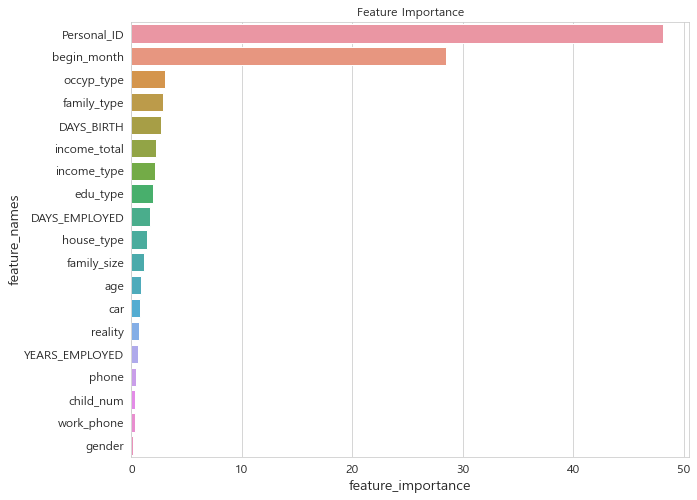

In [57]:
feature_importance = model_tune_cat.get_feature_importance()
feature_names = X_test.columns
    
df_feat =pd.DataFrame({'feature_names':feature_names,'feature_importance':feature_importance}) 
df_feat.sort_values(by=['feature_importance'], ascending=False, inplace=True)

plt.figure(figsize=(10,8))
sns.barplot(data = df_feat,
            x = 'feature_importance',
            y = 'feature_names')

plt.title('Feature Importance')
plt.show()

## Prediction & Evaluation

In [133]:
y_pred = model_tune_cat.predict_proba(X_test)
print(f'log_loss : {log_loss(y_test, y_pred)}')

log_loss : 0.6782064847454993


[[ 173   68  354]
 [  38  543  735]
 [ 106  103 3171]]


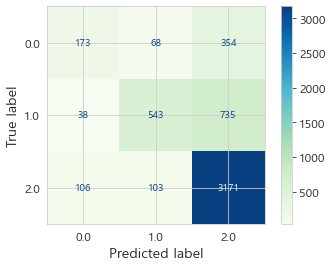

In [134]:
cm = confusion_matrix(y_test,model_tune_cat.predict(X_test))
print(cm)

disp = ConfusionMatrixDisplay(cm, display_labels=model_tune_cat.classes_)
disp.plot(cmap='GnBu')
plt.show()

## Reference

https://optuna.org/
https://hwi-doc.tistory.com/entry/logloss%EA%B0%80-%EB%AD%90%EC%95%BC
https://dacon.io/competitions/official/235713/overview/description
https://catboost.ai/en/docs/
https://hwi-doc.tistory.com/entry/logloss%EA%B0%80-%EB%AD%90%EC%95%BC
https://ssoonidev.tistory.com/107 
https://optuna.org/#key_features 
https://catboost.ai/en/docs/concepts/python-reference_catboostclassifier
https://arxiv.org/abs/1706.09516 
https://hanishrohit.medium.com/whats-so-special-about-catboost-335d64d754ae 
https://dailyheumsi.tistory.com/136
https://dacon.io/competitions/official/235713/codeshare/2768?page=1&dtype=recent
https://dacon.io/competitions/official/235713/codeshare/2519?page=1&dtype=recent
https://dacon.io/competitions/official/235713/codeshare/2750?page=3&dtype=recent 